# Laboratorio 1
**Redes Neuronales para Lenguaje Natural, 2025**

En este laboratorio construiremos analizadores de sentimiento de tres clases (positivo, negativo, neutro) en textos que muestran opiniones, con el objetivo de comparar distintas técnicas de representación de los textos y utilizarlas para alimentar un modelo de redes neuronales.

**Entrega: 9 de octubre de 2025**

**Formato: notebook de Python (.ipynb)**

**No olvidar mantener todas las salidas de cada región de código en el notebook!**

---



## 0. Preparación del entorno

Comenzamos con algunos imports y definiciones.

In [ ]:
! pip install --upgrade gensim numpy scipy
!pip install nltk

import torch
import gensim
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

import os
import random
import torch.optim as optim
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sn


import nltk
nltk.download('punkt') # tokenización básica de oraciones/palabras
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


POLARITY_LABELS = ['Neg','Pos','Neu']
POLARITY_ID = {p:i for (i,p) in enumerate(POLARITY_LABELS) }

  Using cached numpy-2.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.3 MB/s eta 0:00:00


Descargamos los datos de textos de prensa, anotados con una de las siguientes clases: Pos, Neg,Neu. Por más información sobre el dataset, consulte [aquí](https://github.com/pln-fing-udelar/pln-inco-resources/tree/master/sentiment/corpusAnalisisSentimientosEsp)

In [ ]:
! wget https://raw.githubusercontent.com/pln-fing-udelar/pln-inco-resources/master/sentiment/corpusAnalisisSentimientosEsp/prensaUyUnaClase.csv

--2025-09-11 15:13:24--  https://raw.githubusercontent.com/pln-fing-udelar/pln-inco-resources/master/sentiment/corpusAnalisisSentimientosEsp/prensaUyUnaClase.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 216401 (211K) [text/plain]
Saving to: ‘prensaUyUnaClase.csv’

prensaUyUnaClase.cs 100%[===================>] 211.33K  --.-KB/s    in 0.04s   

2025-09-11 15:13:24 (5.72 MB/s) - ‘prensaUyUnaClase.csv’ saved [216401/216401]



Cargamos el dataset en un dataframe de pandas y generamos conjuntos de entrenamiento, desarrollo y testeo.
Este dataset está compuesto por textos con opiniones. Para cada opinión tenemos el texto, un campo que no utilizaremos, y una categoría, que puede ser: Pos, Neg, o Neutro (indicando su polaridad).

In [ ]:
from sklearn.model_selection import train_test_split

dataset_df = pd.read_csv('./prensaUyUnaClase.csv', header=None)
dataset_df.columns = ['text', 'extra', 'polarity']

# Dividimos train y test
temp_df, test_df = train_test_split(dataset_df, test_size=0.2, random_state=42)

# Separamos conjunto de validación
train_df, dev_df = train_test_split(temp_df, test_size=0.2, random_state=42)

print("Training set size:", len(train_df))
print("Development set size:", len(dev_df))
print("Test set size:", len(test_df))

display(dataset_df.iloc[0].text)
display(dataset_df.iloc[0].polarity)





Training set size: 806
Development set size: 202
Test set size: 253


'Según Batlle , esas palabras " son palabras muy ilustrativas en cuanto a el sentimiento que ha sido hasta ahora el que ha prevalecido en el Uruguay , un sentimiento de tolerancia , un sentimiento de comprensión de la situación de el otro "'

'Pos'

En este laboratorio utilizaremos el texto como entrada (columna "text"), y el valor a predecir será la polaridad (columna "polarity").

Imprimimos algunos textos de ejemplo y sus categorías, y luego imprimimos la cantidad de ejemplos de las tres clases en las tres particiones.

In [ ]:
train_text = train_df.loc[:,'text'].to_numpy()
dev_text = dev_df.loc[:,'text'].to_numpy()
test_text = test_df.loc[:,'text'].to_numpy()

train_labels = np.array([POLARITY_ID[l] for l in train_df.loc[:,'polarity']])
dev_labels = np.array([POLARITY_ID[l] for l in dev_df.loc[:,'polarity']])
test_labels = np.array([POLARITY_ID[l] for l in test_df.loc[:,'polarity']])

print(train_text[121])
print(POLARITY_LABELS[train_labels[121]])

print(train_text[27])
print(POLARITY_LABELS[train_labels[27]])

print(train_text[755])
print(POLARITY_LABELS[train_labels[755]])

print(*POLARITY_LABELS, sep='\t')
print(*np.bincount(train_labels), sep='\t')
print(*np.bincount(dev_labels), sep='\t')
print(*np.bincount(test_labels), sep='\t')


Temas Deudas por vivienda Durazno | Víctor D. rodríguez A partir de la próxima semana los residentes de las viviendas podrán concurrir a la oficina local de la ANV para acordar la forma de pago de la deuda , dijo la presidenta
Neu
Astori consideró por otra parte que el documento presentado por las cámaras empresariales con aportes por la pérdida de competitividad es " duro e injusto "
Neg
" Es la satisfacción de ver el trabajo de mi hijo Horacio , que conoce mucho de Criollos y ha hecho una selección fantástica que ha dado sus resultados " , aseguró Horacio Castells Montes
Pos
Neg	Pos	Neu
336	259	211
82	62	58
114	80	59


In [ ]:
print(train_text[1])
print(train_labels[1])

" Es oportuno poner a consideración la oferta fruto de el trabajo de 3 décadas de selección en Polled Hereford , siempre comprando los mejores padres " , dijo el propio Balles
1


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Parte 1

Utilizando pytorch, construir un clasificador tipo Multi-Layered Perceptron (MLP) que clasifique los textos según su sentimiento.
En esta parte, se debe utilizar una representación tipo **bag-of-words (BOW)** para los tweets, la cual se utilizará como entrada de la red.

Puede probar realizar diferentes alternativas dentro de la representación BOW, por ejemplo considerar o no mayúsculas y minúsculas, descartar palabras con listas de stop words, usar N-gramas de orden mayor en vez de palabras simples, o utilizar tf-idf

**Sugerencias:**
* Utilizar la clase CountVectorizer de sklearn
* Limitar el número máximo de features para no quedarse sin memoria
* Reducir la dimensionalidad del vector utilizando, por ejemplo, SVD


    - Convertir las reviews a vectores utilizando la representación de Bag of Words
    - Usar SVD para reducir la dimensionalidad de los vectores a tamaño 500


In [ ]:
vectorizer_bow = CountVectorizer(
    analyzer='word',
    lowercase=True,
    max_features=10000,
    ngram_range=(1,3),
    stop_words=stopwords.words('spanish')
)
vectorizer_bow.fit(train_text)

svd = TruncatedSVD(n_components=500, random_state=42)
svd.fit(vectorizer_bow.transform(train_text))

def transform_data(texts, labels):
    X_bow = vectorizer_bow.transform(texts)
    X_svd = svd.transform(X_bow)
    X_tensor = torch.tensor(X_svd, dtype=torch.float32)
    y_tensor = torch.tensor(labels, dtype=torch.long)
    return X_tensor, y_tensor

X_train, y_train = transform_data(train_text, train_labels)
X_dev, y_dev = transform_data(dev_text, dev_labels)

Crearemos un custom Dataset de pytorch para almacenar nuestros conjuntos de train y test.

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SentimentDataset(X_train, y_train)
dev_dataset = SentimentDataset(X_dev, y_dev)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=64, shuffle=False)

Crear el modelo

In [ ]:
class MLP_bow(nn.Module):
    def __init__(self, input_dim=500, hidden_dim=100, output_dim=3):
        super(MLP_bow, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # sin softmax, porque CrossEntropyLoss lo aplica
        return x

model = MLP_bow().to(device)
print(model)


MLP_bow(
  (fc1): Linear(in_features=500, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)


Entrenamiento

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

for epoch in range(20):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1, Loss: 1.0892
Epoch 2, Loss: 1.0837
Epoch 3, Loss: 1.0790
Epoch 4, Loss: 1.0751
Epoch 5, Loss: 1.0708
Epoch 6, Loss: 1.0672
Epoch 7, Loss: 1.0634
Epoch 8, Loss: 1.0579
Epoch 9, Loss: 1.0545
Epoch 10, Loss: 1.0499
Epoch 11, Loss: 1.0453
Epoch 12, Loss: 1.0413
Epoch 13, Loss: 1.0358
Epoch 14, Loss: 1.0318
Epoch 15, Loss: 1.0254
Epoch 16, Loss: 1.0211
Epoch 17, Loss: 1.0152
Epoch 18, Loss: 1.0101
Epoch 19, Loss: 1.0034
Epoch 20, Loss: 0.9992


Describa las características de su mejor modelo, incluyendo arquitectura e hiperparámetros. Evalúelo sobre el corpus de **dev**, imprimiendo la métrica accuracy, y las métricas macro-precision, macro-recall y macro-F1. Incluya también una matriz de confusión.

---



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Accuracy: 0.4059
Macro Precision: 0.1353
Macro Recall: 0.3333
Macro F1: 0.1925


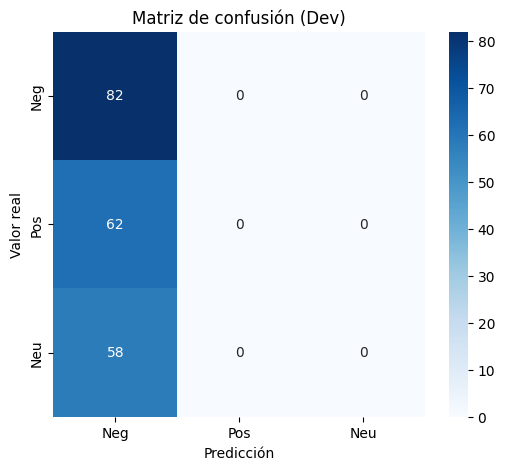

In [ ]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in dev_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall: {recall:.4f}")
print(f"Macro F1: {f1:.4f}")

# ======================================================
# 6. Matriz de confusión
# ======================================================
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=POLARITY_LABELS, columns=POLARITY_LABELS)
plt.figure(figsize=(6,5))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.title("Matriz de confusión (Dev)")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.show()

**Descripción del modelo**:

...

## Parte 2

Utilizando pytorch, construir un clasificador tipo Multi-Layered Perceptron (MLP) que clasifique los textos según su polaridad.
En esta parte, se debe utilizar una representación tipo **centroide de word embeddings** para los tweets, la cual se utilizará como entrada de la red.

Puede probar realizar diferentes alternativas dentro de la representación con word embeddings, por ejemplo considerar o no mayúsculas y minúsculas, o descartar palabras con listas de stop words.

**Sugerencias:**
* Puede utilizar uno de los embeddings que vimos en el taller en clase
* O puede bajar alguna otra colección de embeddings, pero no entrene sus propios embeddings!

In [ ]:
import gensim
from gensim.models import KeyedVectors

! wget https://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.bin.gz
wv = KeyedVectors.load_word2vec_format("./SBW-vectors-300-min5.bin.gz", binary=True)
print(f"Tamaño de embeddings: {wv.vectors.shape}")  # (vocab_size, 300)
embedding_dim = wv.vectors.shape[1]



--2025-09-11 16:11:34--  https://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.bin.gz
Resolving cs.famaf.unc.edu.ar (cs.famaf.unc.edu.ar)... 200.16.17.55
Connecting to cs.famaf.unc.edu.ar (cs.famaf.unc.edu.ar)|200.16.17.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1123304474 (1.0G) [application/x-gzip]
Saving to: ‘SBW-vectors-300-min5.bin.gz’

SBW-vectors-300-min 100%[===================>]   1.05G  17.5MB/s    in 61s     

2025-09-11 16:12:36 (17.5 MB/s) - ‘SBW-vectors-300-min5.bin.gz’ saved [1123304474/1123304474]

Tamaño de embeddings: (1000653, 300)


Convertir textos a centroides de embeddings

In [ ]:
def text_to_centroid(texts, wv, embedding_dim):
    vectors = []
    for text in texts:
        tokens = word_tokenize(text.lower())  # pasamos a minúsculas
        valid_tokens = [t for t in tokens if t in wv.key_to_index]
        if valid_tokens:
            vecs = [wv[t] for t in valid_tokens]
            centroid = np.mean(vecs, axis=0)
        else:
            centroid = np.zeros(embedding_dim)  # vector cero si no hay palabras
        vectors.append(centroid)
    return np.array(vectors, dtype=np.float32)

X_train = text_to_centroid(train_text, wv, embedding_dim)
X_dev   = text_to_centroid(dev_text, wv, embedding_dim)
y_train = np.array(train_labels, dtype=np.int64)
y_dev   = np.array(dev_labels, dtype=np.int64)


Dataset y DataLoader

In [ ]:
class EmbeddingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = EmbeddingDataset(X_train, y_train)
dev_dataset   = EmbeddingDataset(X_dev, y_dev)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
dev_loader   = DataLoader(dev_dataset, batch_size=64, shuffle=False)


MODELO


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MLP_embeddings(nn.Module):
    def __init__(self, input_dim=embedding_dim, hidden_dim=200, output_dim=3):
        super(MLP_embeddings, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP_embeddings().to(device)
print(model)


MLP_embeddings(
  (fc1): Linear(in_features=300, out_features=200, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=200, out_features=3, bias=True)
)


ENTRENAMIENTO


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

for epoch in range(20):
    model.train()
    running_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1, Loss: 1.0840
Epoch 2, Loss: 1.0650
Epoch 3, Loss: 1.0473
Epoch 4, Loss: 1.0265
Epoch 5, Loss: 1.0034
Epoch 6, Loss: 0.9688
Epoch 7, Loss: 0.9385
Epoch 8, Loss: 0.9220
Epoch 9, Loss: 0.8954
Epoch 10, Loss: 0.8708
Epoch 11, Loss: 0.8672
Epoch 12, Loss: 0.8411
Epoch 13, Loss: 0.8279
Epoch 14, Loss: 0.8318
Epoch 15, Loss: 0.8171
Epoch 16, Loss: 0.7937
Epoch 17, Loss: 0.7816
Epoch 18, Loss: 0.7791
Epoch 19, Loss: 0.7721
Epoch 20, Loss: 0.7512


Describa las características de su mejor modelo, incluyendo arquitectura e hiperparámetros. Evalúelo sobre el corpus de **dev**, imprimiendo la métrica accuracy, y las métricas macro-precision, macro-recall y macro-F1. Incluya también una matriz de confusión.



Accuracy: 0.6188
Macro Precision: 0.6162
Macro Recall: 0.6043
Macro F1: 0.6045


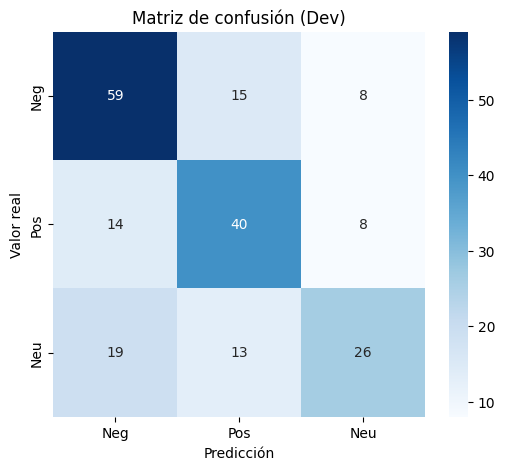

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in dev_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall: {recall:.4f}")
print(f"Macro F1: {f1:.4f}")


cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=POLARITY_LABELS, columns=POLARITY_LABELS)
plt.figure(figsize=(6,5))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.title("Matriz de confusión (Dev)")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.show()

**Descripción del modelo**:

...

Repita el paso anterior, utilizando la misma arquitectura, pero cambiando los embeddings utilizados. Compare los resultados y comente.

In [ ]:
from gensim.models import KeyedVectors
from huggingface_hub import hf_hub_download

# Descargar y cargar los embeddings
file_path = hf_hub_download(
    repo_id="Word2vec/wikipedia2vec_eswiki_20180420_100d",
    filename="eswiki_20180420_100d.txt"
)
wv_wiki = KeyedVectors.load_word2vec_format(file_path)
print(f"Tamaño embeddings Wikipedia: {wv_wiki.vectors.shape}")
embedding_dim_wiki = wv_wiki.vectors.shape[1]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


eswiki_20180420_100d.txt:   0%|          | 0.00/1.41G [00:00<?, ?B/s]

Tamaño embeddings Wikipedia: (1828809, 100)


In [ ]:
from nltk.tokenize import word_tokenize
import numpy as np

def text_to_centroid_wiki(texts, wv, embedding_dim):
    vectors = []
    for text in texts:
        tokens = word_tokenize(text.lower())
        valid_tokens = [t for t in tokens if t in wv.key_to_index]
        if valid_tokens:
            vecs = [wv[t] for t in valid_tokens]
            centroid = np.mean(vecs, axis=0)
        else:
            centroid = np.zeros(embedding_dim)
        vectors.append(centroid)
    return np.array(vectors, dtype=np.float32)

X_train_wiki = text_to_centroid_wiki(train_text, wv_wiki, embedding_dim_wiki)
X_dev_wiki   = text_to_centroid_wiki(dev_text, wv_wiki, embedding_dim_wiki)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class EmbeddingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset_wiki = EmbeddingDataset(X_train_wiki, y_train)
dev_dataset_wiki   = EmbeddingDataset(X_dev_wiki, y_dev)

train_loader_wiki = DataLoader(train_dataset_wiki, batch_size=64, shuffle=True)
dev_loader_wiki   = DataLoader(dev_dataset_wiki, batch_size=64, shuffle=False)


In [ ]:
class MLP_embeddings(nn.Module):
    def __init__(self, input_dim=embedding_dim_wiki, hidden_dim=200, output_dim=3):
        super(MLP_embeddings, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_wiki = MLP_embeddings().to(device)
print(model_wiki)


MLP_embeddings(
  (fc1): Linear(in_features=100, out_features=200, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=200, out_features=3, bias=True)
)


Epoch 1, Loss: 1.0752
Epoch 2, Loss: 1.0596
Epoch 3, Loss: 1.0494
Epoch 4, Loss: 1.0335
Epoch 5, Loss: 1.0232
Epoch 6, Loss: 1.0056
Epoch 7, Loss: 0.9871
Epoch 8, Loss: 0.9670
Epoch 9, Loss: 0.9520
Epoch 10, Loss: 0.9429
Epoch 11, Loss: 0.9432
Epoch 12, Loss: 0.9196
Epoch 13, Loss: 0.9121
Epoch 14, Loss: 0.9038
Epoch 15, Loss: 0.8956
Epoch 16, Loss: 0.8855
Epoch 17, Loss: 0.8866
Epoch 18, Loss: 0.8672
Epoch 19, Loss: 0.8674
Epoch 20, Loss: 0.8505

Accuracy: 0.5495
Macro Precision: 0.5445
Macro Recall: 0.5322
Macro F1: 0.5335


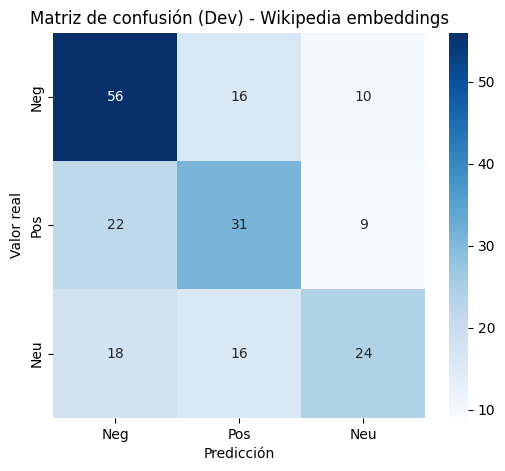

In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_wiki.parameters(), lr=0.001, weight_decay=1e-4)

# Entrenamiento
for epoch in range(20):
    model_wiki.train()
    running_loss = 0
    for inputs, labels in train_loader_wiki:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_wiki(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_wiki):.4f}")

# Evaluación
model_wiki.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in dev_loader_wiki:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_wiki(inputs)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall: {recall:.4f}")
print(f"Macro F1: {f1:.4f}")

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=POLARITY_LABELS, columns=POLARITY_LABELS)
plt.figure(figsize=(6,5))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.title("Matriz de confusión (Dev) - Wikipedia embeddings")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.show()


**Comentarios**:

...

## Parte 3 (opcional):
Elija uno de los clasificadores anteriores y realice una búsqueda automatizada de hiperparámetros del modelo. Por ejemplo, puede utilizar una búsqueda en grilla completa o una búsqueda aleatoria, eligiendo diferente cantidad de capas, número unidades por capa, funciones de activación, y valores de learning rate. Intente encontrar el mejor clasificador posible, comparándolos sobre el corpus de **dev**.

In [ ]:
# su código aquí


Describa las características de su mejor modelo, incluyendo arquitectura e hiperparámetros. Evalúelo sobre el corpus de **dev**, imprimiendo la métrica accuracy, y las métricas macro-precision, macro-recall y macro-F1. Incluya también una matriz de confusión.

In [ ]:
# su código aquí


## Parte 4:

Elija el mejor clasificador de todos los construidos en las partes anteriores, comparándolos utilizando la medida macro-F1, y evalúelo sobre el corpus de **test**, imprimiendo la métrica accuracy, y las métricas macro-precision, macro-recall y macro-F1.

In [ ]:
# su código aquí


Despliege la matriz de confusión sobre el corpus de **test** para las tres clases (P, N, NEU) para el mejor clasificador construido en las partes anteriores.

In [ ]:
# su código aquí


Analice los resultados, y responda, al menos, las siguientes preguntas:

1.   ¿Cuál fue la representación que funcionó mejor? Describa brevemente sus características.
2.   ¿Cuál es la forma del modelo? Indique cantidad de capas, unidades, y funciones de activación. Puede usar el método print() sobre el modelo para imprimir la forma del modelo.
3.   Indique qué categoría o categorías fueron las más difíciles de aprender para su clasificador. ¿La categoría más difícil es la misma para el mejor clasificador de las partes 1 y 2 (y la parte 3 si la hizo)?

( sus respuestas aquí)
